In [1]:

suppressMessages(library(tidyverse))
suppressMessages(library(parallel))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratData))
suppressMessages(library(patchwork))
suppressMessages(library(Matrix))
suppressMessages(library(viridis))
suppressMessages(library(cowplot))
suppressMessages(library(ggsci))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(LSD))
suppressMessages(library(readxl))
suppressMessages(library(ggrepel))
suppressMessages(library(randomForest))
suppressMessages(library(harmony))

# Plot each clusters
myHighlightDimPlot = function(seuratObj, highlightBy, size=1, alpha=1, showAllPoints=FALSE, ...) {
    umapTb = as_tibble(seuratObj@reductions$umap@cell.embeddings)
    if (!identical(rownames(seuratObj@reductions$umap@cell.embeddings), rownames(seuratObj@meta.data)))
        stop("Error: cell names not identical!")
    umapTb = cbind(umapTb, seuratObj@meta.data)
    highlightByClass = sort(unique(umapTb[[highlightBy]]))
    gpList = lapply(highlightByClass, function(cl) {
        subUmapTb = subset(umapTb, umapTb[[highlightBy]] == cl)
        if (showAllPoints) {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void() 
        } else {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void()
        }
        return(gp)
    })
    gpAll = plot_grid(plotlist=gpList, labels=highlightByClass, ...)
    return(gpAll)
}

In [2]:
seurat=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/Insular_renew_1016/from-zmy/Insular_raw_unfil_1016.rds')
seurat


An object of class Seurat 
21350 features across 136095 samples within 1 assay 
Active assay: RNA (21350 features, 0 variable features)

In [3]:
table(seurat@meta.data$group)
length(unique(seurat@meta.data$group))


 86_LC0613  87_LC0613  88_LC0613  89_LC0613  90_LC0613 MQ277R-301 MQ277R-320 
     24456      16443      14776       8035      20000      18068      18071 
MQ277R-376 
     16246 

[1] 8

In [4]:
#去除 median nfeature <500
df_meta=seurat@meta.data
group_med_feature=df_meta %>% group_by(group)  %>% summarise(med=median(nFeature_RNA))
select_group=group_med_feature[group_med_feature$med > 500,]$group
#被去掉的文库
length(group_med_feature$group)
group_med_feature[group_med_feature$med < 500,]$group
length(select_group)

seurat=subset(seurat,group %in% select_group)



[1] 8

character(0)

[1] 8

In [5]:
seurat

An object of class Seurat 
21350 features across 136095 samples within 1 assay 
Active assay: RNA (21350 features, 0 variable features)

In [6]:
MTGenes = c("ND6","COX3","COX1","ND5","ND4","ND2","ND4L","ATP8","CYTB","COX2","ND3","ATP6","ND1")
seurat[["percent.mt"]] <- PercentageFeatureSet(seurat,features  = MTGenes)


In [7]:
# Basic filtering
#修改为200
oriCellNum = ncol(seurat)
seurat$countFeatureRatio = seurat$nCount_RNA / seurat$nFeature_RNA
seurat = subset(seurat, nFeature_RNA > 300 & percent.mt < 5 & countFeatureRatio > 1.2)
cellNum1 = ncol(seurat)
cellNum1
message("Filter ratio: ", cellNum1/oriCellNum)



[1] 122939

Filter ratio: 0.903332231162056



In [1]:
122939/0.903332231162056

[1] 136095

In [10]:
seurat$libId=seurat$group

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


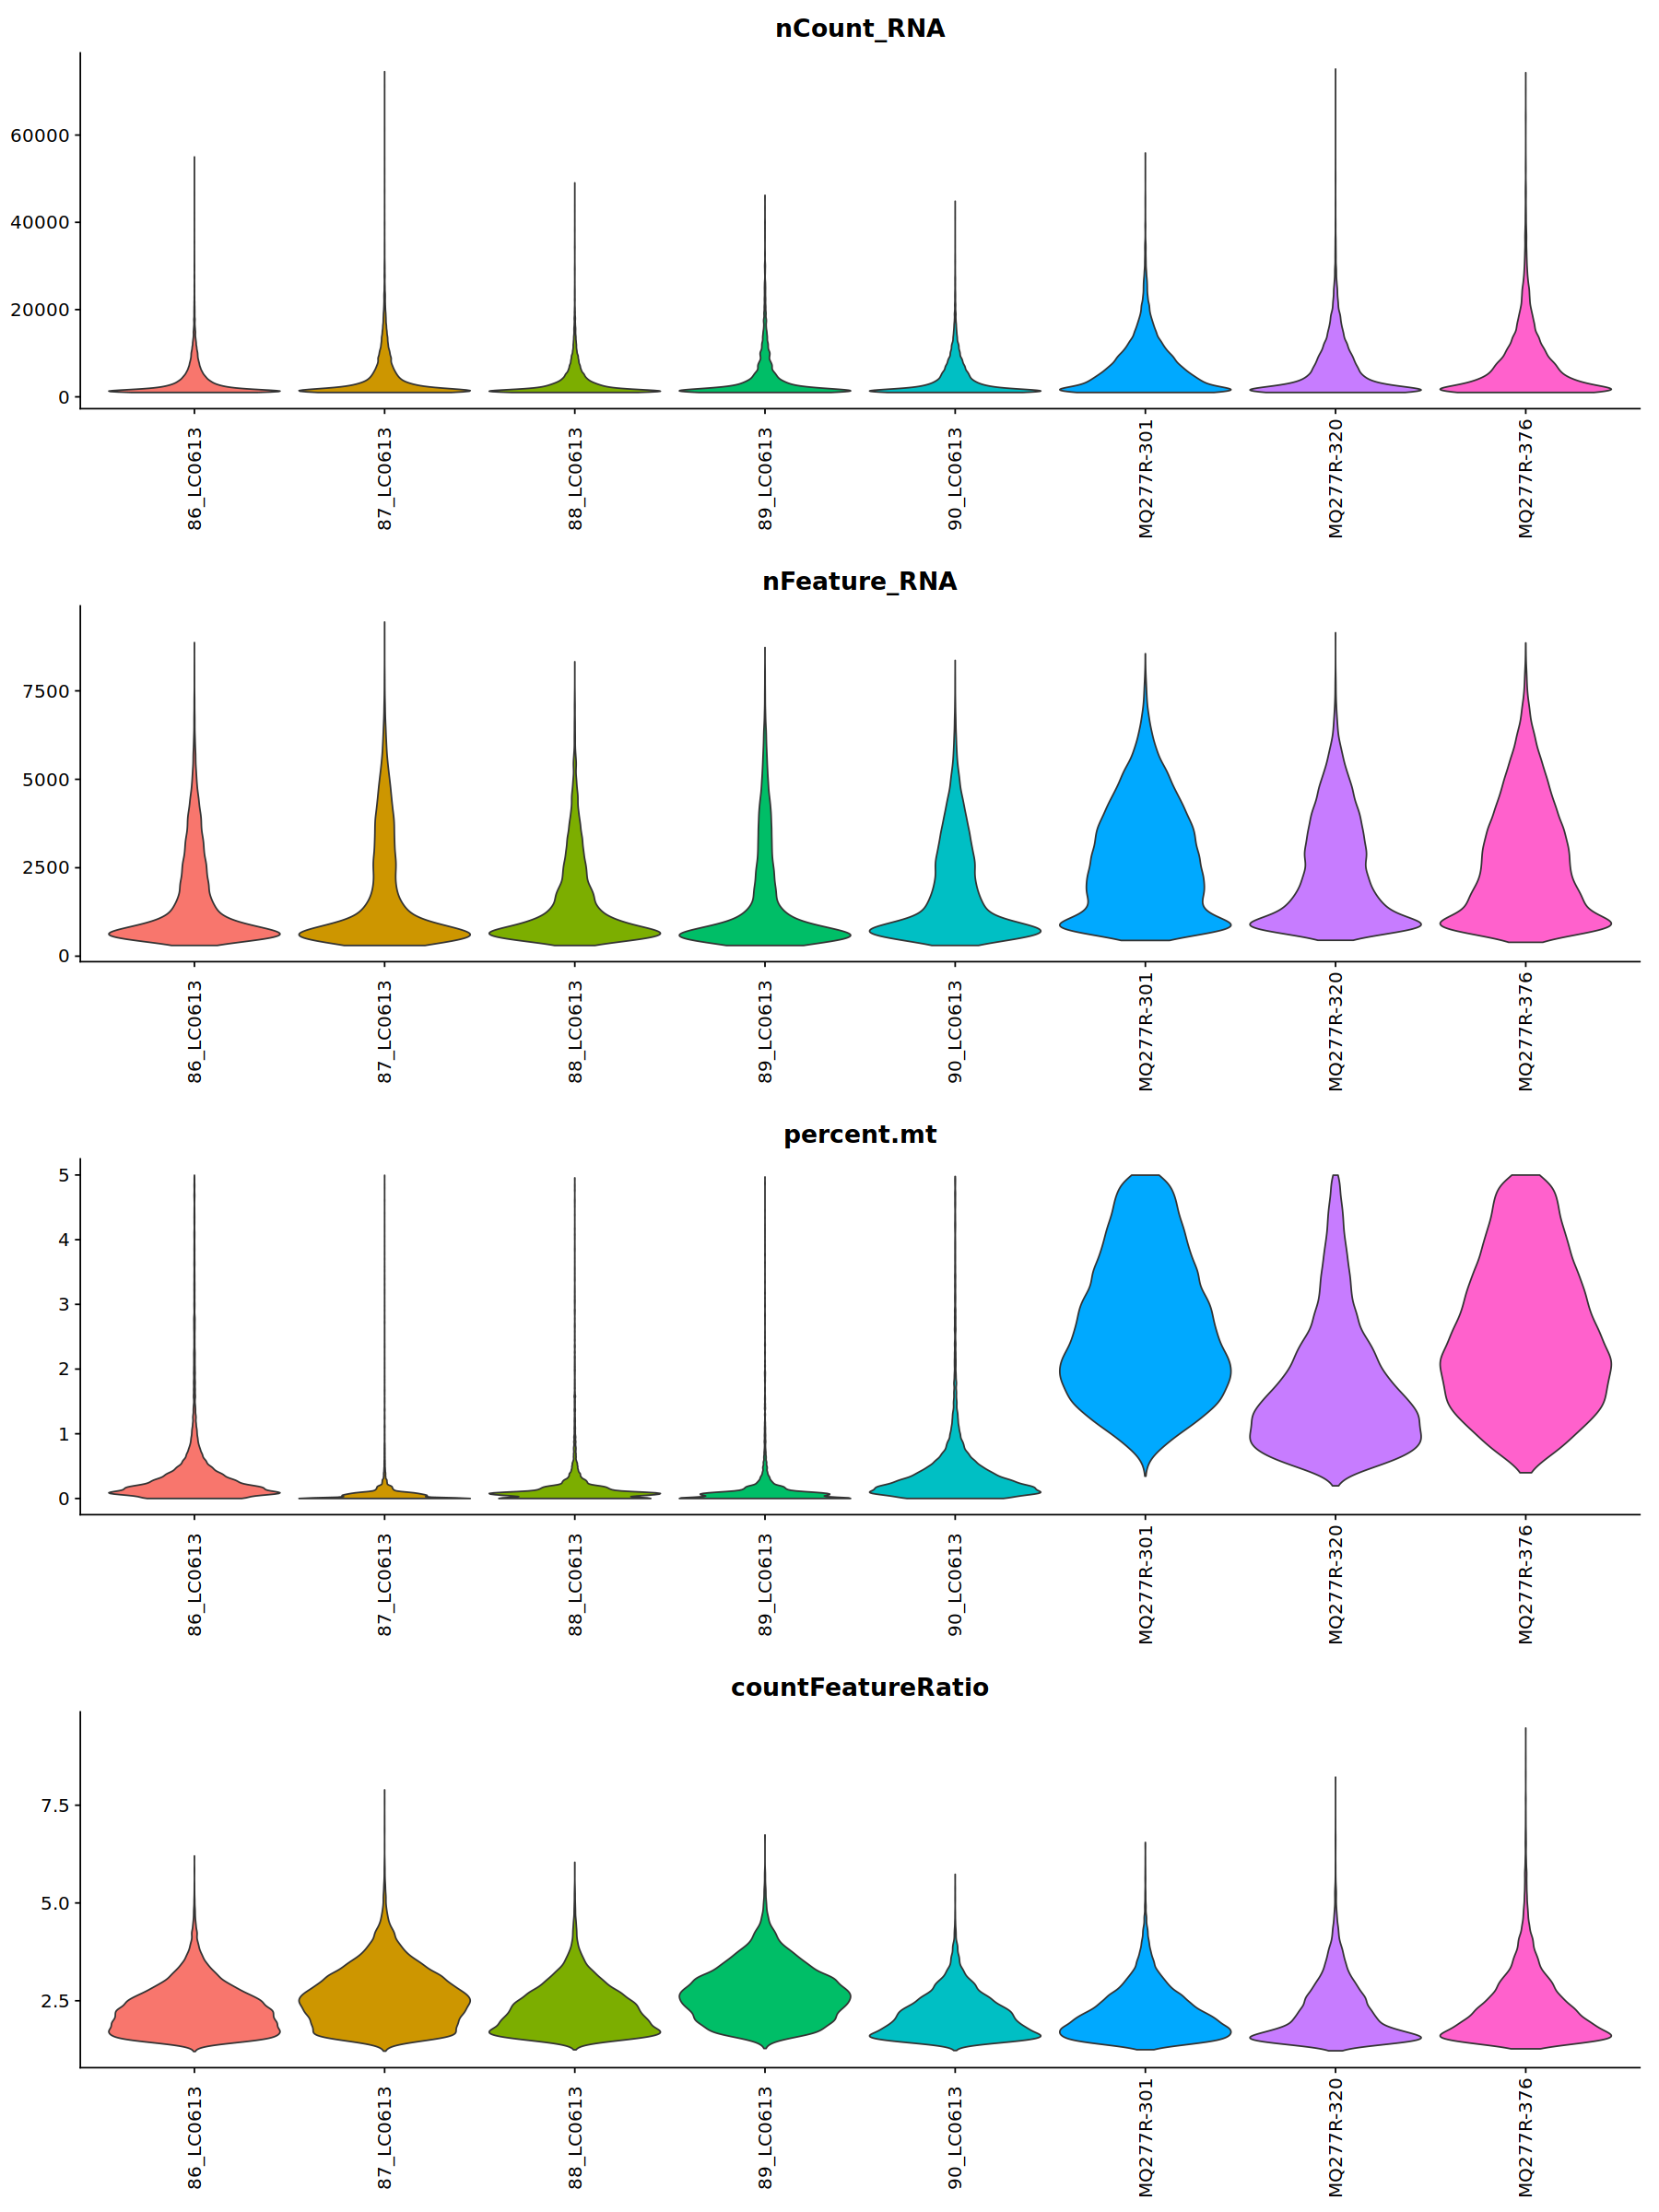

In [11]:
Idents(seurat) = "libId"
options(repr.plot.width=15, repr.plot.height=20)
print(plot_grid(
    plotlist = lapply(c("nCount_RNA", "nFeature_RNA", "percent.mt", "countFeatureRatio"), function(x) {
        p = VlnPlot(seurat, features=x, pt.size=0) + 
            theme(axis.text.x=element_text(vjust=0.5, hjust=0.5, angle=90), axis.title.x = element_blank()) +
            guides(fill=FALSE)
        return(p)
    }), 
    ncol=1, align="hv", axis="tblr"
))

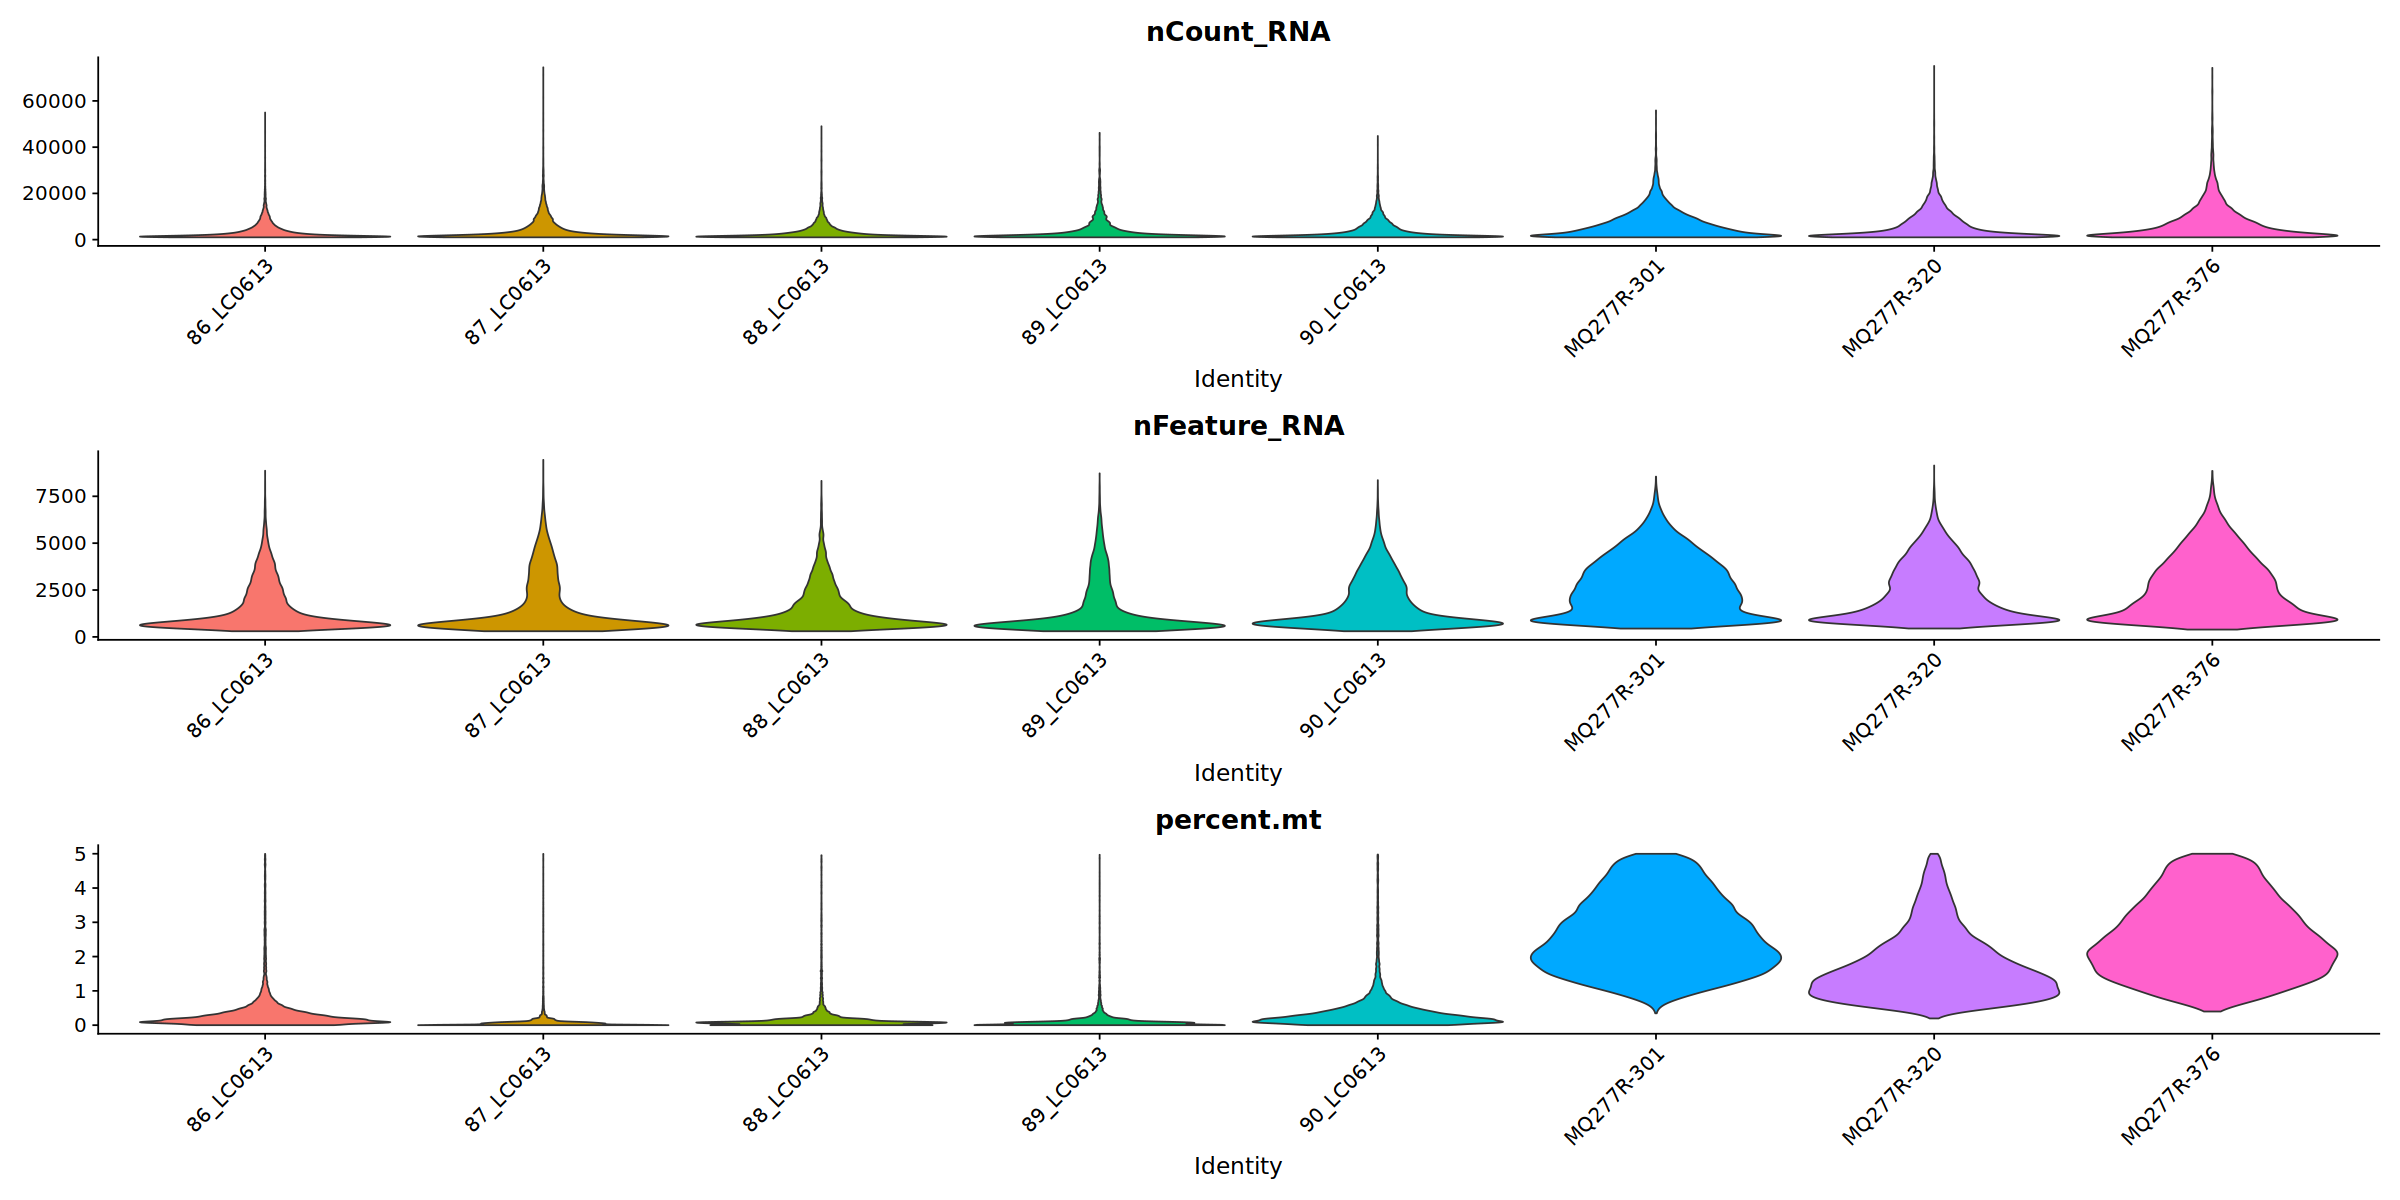

In [12]:
options(repr.plot.width=20, repr.plot.height=10)
Idents(seurat) = "libId"
VlnPlot(seurat, features=c("nCount_RNA", "nFeature_RNA", "percent.mt"), pt.size=0, ncol=1)

In [13]:
seurat

An object of class Seurat 
21350 features across 122939 samples within 1 assay 
Active assay: RNA (21350 features, 0 variable features)

In [14]:
#更新版本
saveRDS(seurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/speciesCompare/Insular_renew_1016/batch_normalize_renew_1031_Insular/Insular_snrna_all_soupX_fil_batch2_1016.rds')
